# Mask R-CNN - Brain Tumor

#### Requirements

In [1]:
# !pip install tensorflow==2.5
# !pip install keras==2.6.0
# !pip install numpy==1.20.3
# !pip install tf-estimator-nightly==2.8.0.dev2021122109

#### Libraries

In [28]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

import scipy

# These imports are the files of the mrcnn model
import mrcnn
from mrcnn.config import Config
import mrcnn.utils as utils 
import mrcnn.model as modellib
import mrcnn.visualize as visualize 
from mrcnn.model import log

%matplotlib inline 

In [33]:
import warnings
warnings.filterwarnings("ignore")

#### Initialize my paths and variables

In [30]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
# Data Path
TRAIN_PATH = r'D:\ITI\Computer vision\Dataset\Brain scans\Tumor\train'
TEST_PATH = r'D:\ITI\Computer vision\Dataset\Brain scans\Tumor\test'

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

#### Configurations

Extend the Config class and override some of its parameters

In [31]:
# Configuration for training our dataset. 
# Derives from the base Config class and overrides values specific to our dataset.

class BrainConfig(Config):
    
    # Give the configuration a recognizable name
    NAME = "Brain"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nucleus

    # Set my image min and max dimensions to 512 to make them with the same shape
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Set the anchor sizes (Here it will generate anchors for object proposals with sizes of 8x8, 16x16, 64x64, 128x128, 256x256)
    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  # anchor side in pixels

    # Max number or Regions of interest
    TRAIN_ROIS_PER_IMAGE = 800

    # set number of epoch
    STEPS_PER_EPOCH = 200

    # set validation steps 
    VALIDATION_STEPS = 50
    
config = BrainConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

#### Notebook Preferences (Set all the plots to the same size)

In [5]:
# Provide a central point to control graph sizes. 
#Change the default size attribute to control the size of plotted images.
def get_ax(rows=1, cols=1, size=8):
    
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

#### Dataset

Extend the Dataset class and add a method to load the dataset, `load_data()`, and override the following methods:

* load_image()
* load_mask()

In [6]:
class ShapesDataset(utils.Dataset):
    
    def load_data(self, mode, dataset_dir):
        
        # Add classe Tumor to the classes
        self.add_class("Brain", 1, "Tumor")
        
        # If mode is train so load the data from the training dataset
        if mode == "train":
            # Get all the train IDs
            train_ids= os.listdir(os.path.join(dataset_dir, "TRAIN"))
            # Loop over the IDs
            for id_ in train_ids[1:]:
                    # Get the path of the current image
                    path = os.path.join(dataset_dir, "TRAIN", id_)
                    # Get the path of the mask of the current image
                    mask_path = os.path.join(dataset_dir, "TRAIN/TRAIN_masks", id_.replace('.jpg', '.png'))
                    # Add to image_info local variable the information of image_id, image_path, mask_path
                    self.add_image("Brain", image_id=id_, path=path, mask_path=mask_path)

        # If mode is val so load the data from the validation dataset          
        if mode == "val":
            val_ids = os.listdir(os.path.join(dataset_dir, "TEST"))
            for id_ in val_ids[1:]:
                    # Get the path of the current image
                    path = os.path.join(dataset_dir, "TEST", id_)
                    # Get the path of the mask of the current image
                    mask_path = os.path.join(dataset_dir, "TEST/TEST_masks", id_.replace('.jpg', '.png'))
                    # Add to image_info local variable the information of image_id, image_path, mask_path
                    self.add_image("Brain", image_id=id_, path=path, mask_path=mask_path)

    # Load an image using its ID
    def load_image(self, image_id):
        # Get the image information
        info = self.image_info[image_id]
        # Get the path of the image
        path = info["path"]
        # Read the image
        img = imread(path)
        # Resize the image to a specific size ((512,512) in our case)
        img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)

        return img
    
    # Load a mask using its image ID
    def load_mask(self, image_id):
        # Get the image information
        info = self.image_info[image_id]
        # Get the path of the mask
        mask_path = info["mask_path"]
        # Read the image
        mask = imread(mask_path)
        # Convert all the masks to a gray scale images
        mask= rgb2gray(mask)
        # Add a third dimension to the mask
        if mask.ndim == 2:
          mask = np.expand_dims(mask, axis=-1) # add third dimension if necessary
        # convert to float type
        mask = mask.astype(float)
        # Save the original mask size
        original_size = mask.shape[:2]
        # Initialize Scale that the mask will be shaped into
        scale = (config.IMAGE_SHAPE[0] / original_size[0], config.IMAGE_SHAPE[1] / original_size[1],1)
        # Resize the mask of the mask match the size of the corresponding resized image
        mask = scipy.ndimage.zoom(mask, zoom=scale, order=0)
        
        # Defining class_ids, assuming there is only one class (tumor)
        class_ids = np.array([1])
        
        return mask, class_ids

        

In [7]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_data("train",TRAIN_PATH)
# Define some dataset parameters such as number of classes and number of images
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_data("val", TEST_PATH)
# Define some dataset parameters such as number of classes and number of images
dataset_val.prepare()

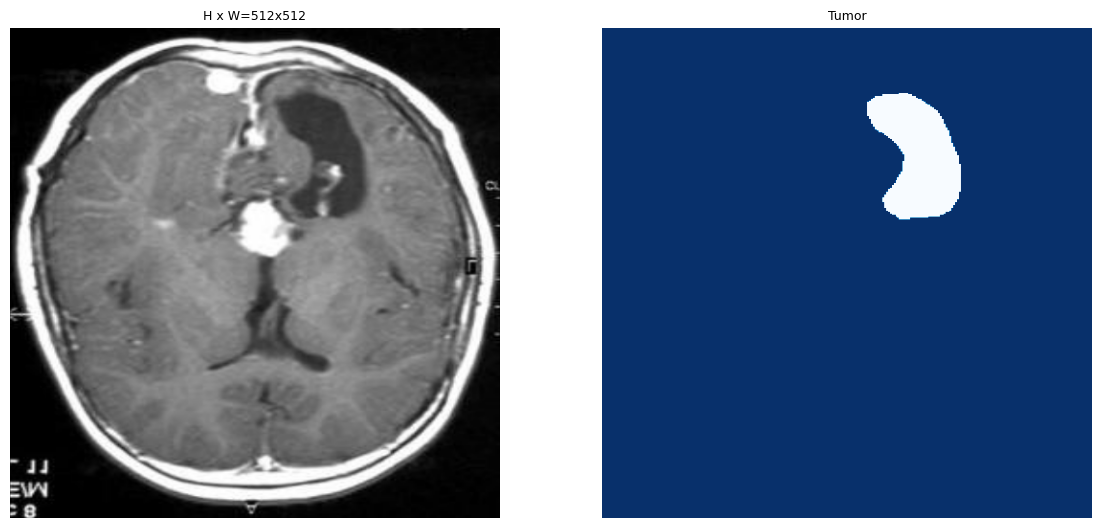

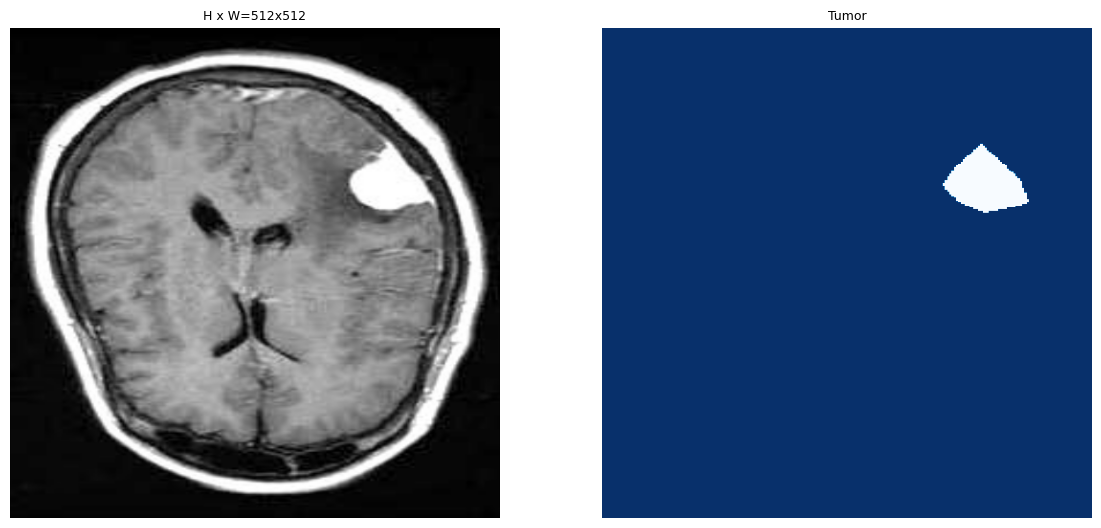

In [8]:
# Load and display random samples (2 Samples in this case)
image_ids = np.random.choice(dataset_train.image_ids, 2)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_single_mask(image, mask, class_ids, dataset_train.class_names, limit=1)

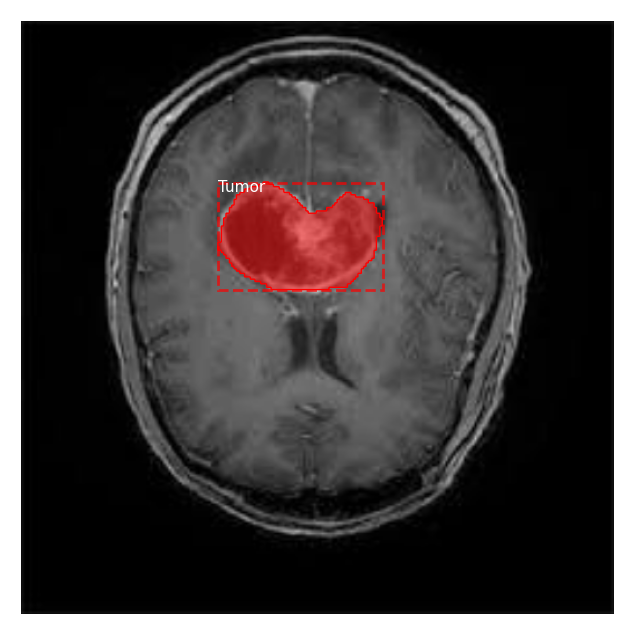

In [18]:
# seleect a random sample from the train data
image_id = random.choice(dataset_train.image_ids)
# Load image and its ground truth mask for visualization
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =mrcnn.model.load_image_gt(dataset_train, config, image_id, vis=1 )

# Display a random sample colorized with the mask
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

#### Ceate Model

In [23]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [24]:
# Initiate our model with coco weights (we can use 'coco', 'imagenet' or 'last')
init_with = "coco"

# Load the weights of the model based on our choice
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)

elif init_with == "coco":
    # Load weights trained on MS COCO, but skip some layers because they are task dependent
    # mrcnn_class_logits layer is responsible for predicting the class probabilities for each region proposal
    # mrcnn_bbox_fc and mrcnn_bbox layers are responsible for predicting the bounding box coordinates.
    # mrcnn_mask layer is responsible for predicting the binary mask for each instance.
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
    
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

#### Training

Only train the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, we passed `layers='heads'` to the `train()` function.

In [13]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=5,
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: d:\Proj_seg\logs\shapes20230414T1807\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDis

In [14]:
# Save weights
model_path = os.path.join(MODEL_DIR, "trained_mask_rcnn_shapes3.h5")
model.keras_model.save_weights(model_path)

## Detection

In [34]:
# Make a TestConfig class that extends our BrainConfig class but used for testing setting IMAGES_PER_GPU= 1
class TestConfig(BrainConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

test_config = TestConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=test_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
model_path = r'd:\\Proj_seg\\logs\\trained_mask_rcnn_shapes3.h5'

# Load trained weights and check if the path was empty srtring
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  d:\\Proj_seg\\logs\\trained_mask_rcnn_shapes3.h5


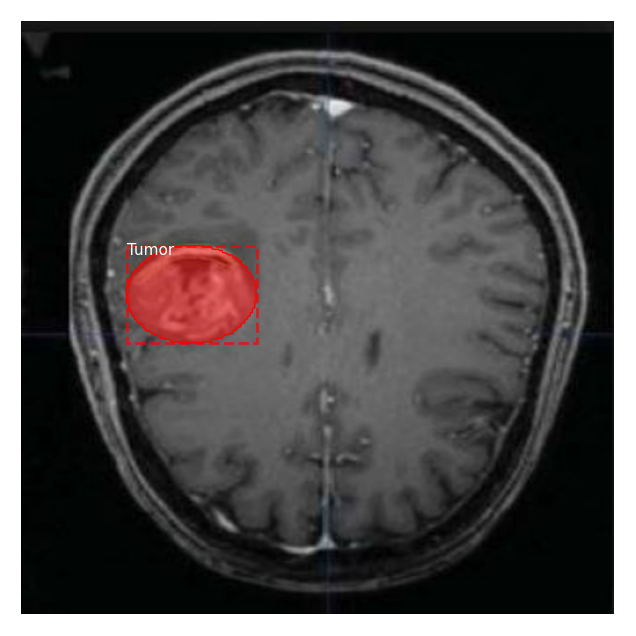

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  241.11266  float64
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  137.21266  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


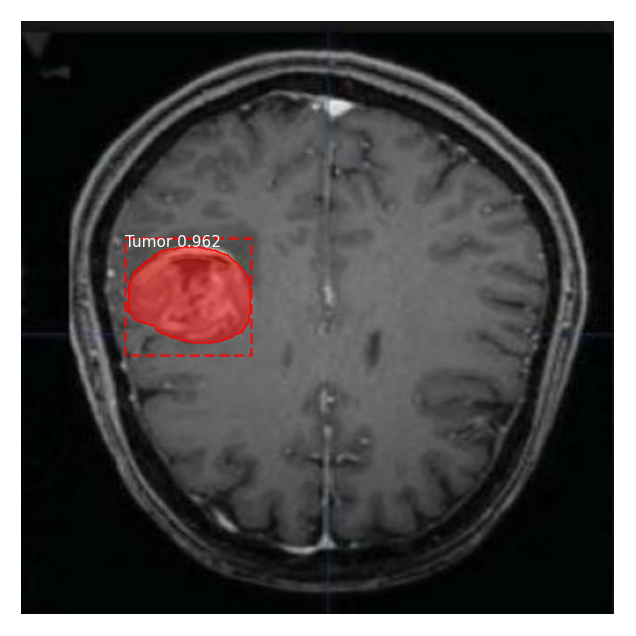

In [41]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(dataset_val, test_config, image_id, vis=1)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [12]:
# Compute Average pericision, IoU and Dice coefficient for the test dataset
image_ids = dataset_val.image_ids[1:]
APs = []
IoUs= []
Dices= []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, test_config, image_id, vis=1)
    
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute IoU
    iou= utils.compute_iou_masks(r["masks"], gt_mask)
    IoUs.append(iou)

    # Compute Dice
    dice= utils.compute_dice(r["masks"], gt_mask)
    Dices.append(dice)

    # Compute AP
    AP, precisions, recalls, overlaps =utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("Average pericesion : ", np.mean(APs))
print("Average IoU : ", np.mean(IoUs))
print("Average Dice : ", np.mean(Dices))

Average pericesion :  0.8039115646258503
Average IoU :  0.6297234376519059
Average Dice :  0.7223869404848255


In [42]:
X_test = np.zeros((len(dataset_val.image_ids), config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3), dtype=np.uint8)

print('Getting and resizing test images ... ')
for n, id_ in enumerate(dataset_val.image_ids):
    img , image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, test_config, id_, vis=1)
    img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images ... 


Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


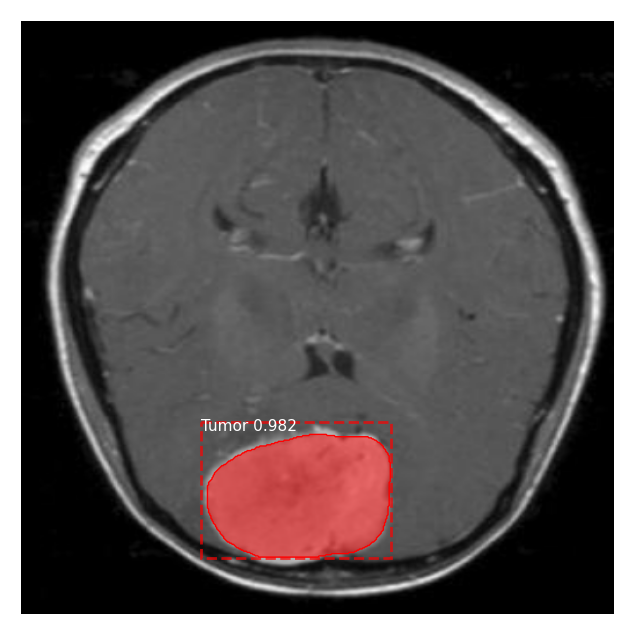

In [60]:
# Choose a number of any instance within the range to show the predicted mask
i= int(input("Enter any number betwwen 0:  and {} to show he results".format(len(X_test))))
results = model.detect([X_test[i]], verbose=1)

r = results[0]
visualize.display_instances(X_test[i], r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())
